## ECG Classification 

Adapted from https://www.kaggle.com/gregoiredc/arrhythmia-on-ecg-classification-using-cnn

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sys

from matplotlib import pyplot as plt

from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

# Note in order to run on colab you need to download the MIT-BIH CSV files. See ReadMe file

from google.colab import drive
drive.mount('/content/drive') #<-- Path should be the folder in which the libary of code is located
sys.path.insert(0,'/content/drive/Shareddrives/ECG/')


Mounted at /content/drive


In [3]:
df_train = pd.read_csv("/content/drive/Shareddrives/ECG/mitbih_train.csv", header=None) #<--- Read the training data from CSV
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("/content/drive/Shareddrives/ECG/mitbih_test.csv", header=None) #<--- Read the test data from CSV

Y = np.array(df_train[187].values).astype(np.int16)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int16)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

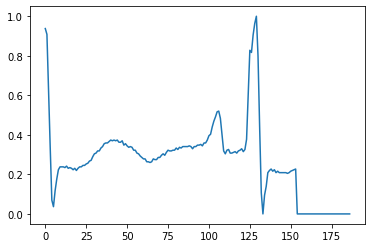

In [13]:
# Plotting an Example Data
plt.plot(X[10])
plt.title(f'ECG Plot 10')
plt.ylabel('Sample #')
plt.xlabel('Amplitude')

## Dateset Composition

Knowledge of each dataset is an critial factor in considereing how the algorithm is performing. 

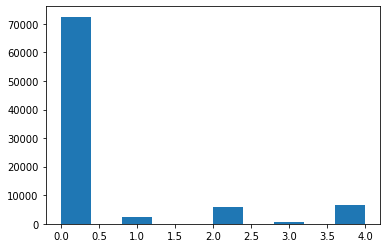

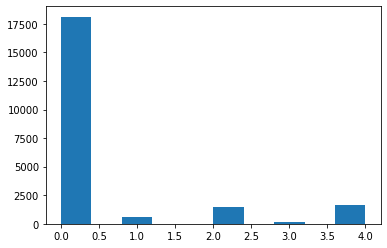

72471
87554
0.8277291728533248
18118
21892
0.8276082587246483
{0: 0.24162492583240192, 1: 7.877103013945119, 2: 3.0253628196268143, 3: 27.317940717628705, 4: 2.7228735810915876}


In [4]:
plt.hist(Y)
plt.show()

plt.hist(Y_test)
plt.show()

print(len(np.where(Y==0)[0]))
print(len(Y))
print(float(len(np.where(Y==0)[0]))/float(len(Y)))

print(len(np.where(Y_test==0)[0]))
print(len(Y_test))
print(float(len(np.where(Y_test==0)[0]))/float(len(Y_test)))

'''
# --> Weight Imbalance Fix

#cw = class_weight.compute_class_weight('balanced', np.unique(Y), Y)
#cwd = dict(cw[i:i+2] for i in range(0, len(cw), 2))
#cw = dict(zip(np.unique(Y), class_weight.compute_class_weight('balanced', np.unique(Y), Y)))
'''

## Model Architecture Used


*   Convolutional Neural Network Layer
*   Max Pooling
*   Dropout



In [8]:
# 
def get_model():
  with tf.device('/device:GPU:0'):
    nclass = 5

    inp = Input(shape=(187, 1))
    
    img_1 = Convolution1D(16, kernel_size=5, strides=1, activation=activations.relu, padding="same")(inp)
    img_1 = Convolution1D(16, kernel_size=5, strides=1, activation=activations.relu, padding="same")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)

    img_1 = Convolution1D(32, kernel_size=3, strides=1, activation=activations.relu, padding="same")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, strides=1, activation=activations.relu, padding="same")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)

    img_1 = Convolution1D(16, kernel_size=3, strides=1, activation=activations.relu, padding="same")(img_1)
    img_1 = Convolution1D(16, kernel_size=3, strides=2, activation=activations.relu, padding="same")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)

    img_1 = Convolution1D(16, kernel_size=3, strides=1, activation=activations.relu, padding="same")(img_1)
    img_1 = Convolution1D(16, kernel_size=3, strides=2, activation=activations.relu, padding="same")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.1)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

model = get_model()
file_path = "/content/drive/MyDrive/baseline_cnn_mitbih.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 187, 16)           96        
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 187, 16)           1296      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 93, 16)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 93, 16)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 93, 32)            1568      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 93, 32)            3104

## Metircs Used for Measuring Classification Performance

*   Precsion $ = \frac{\text{TP}}{\text{TP} + \text{FP}}$

*   Recall $ = \frac{\text{TP}}{\text{TP} + \text{FN}}$

*   F1 $ = \frac{\text{TP}}{\text{TP} + 0.5(\text{FP} + \text{FN})}$

Which metrirc is more important for our aplication?

A true negative(TN) is a real issue because that could mean the person's life is in danger since we didnt detect an arrhythmia. A false positive(FP) isnt as much of an issue, but is still a concern. Here we have a situation where it is much worse to have a TN than a FP.

A true positive(TP) and false negative(FN) are the algorithm doing its job correctly.






In [12]:
hist = 0
with tf.device('/device:GPU:0'):
  hist = model.fit(X, Y, epochs=20, batch_size = 32, verbose=1, callbacks=callbacks_list, validation_split=0.15, class_weight=None)

  #hist = model.fit(X, Y, epochs=25,verbose=1, callbacks=callbacks_list, validation_split=0.15)
  #model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

F1 = f1_score(Y_test, pred_test, average="macro")
acc = accuracy_score(Y_test, pred_test)

print(f'F1 Test Score = {F1:.3f}')
print(f'Test Accuracy Score = {acc:.3f}')

Epoch 1/20
2326/2326 [==============================] - 12s 5ms/step - loss: 0.1115 - acc: 0.9688 - val_loss: 0.1030 - val_acc: 0.9725

Epoch 00001: val_acc did not improve from 0.97350
Epoch 2/20
2326/2326 [==============================] - 12s 5ms/step - loss: 0.1095 - acc: 0.9695 - val_loss: 0.0984 - val_acc: 0.9750

Epoch 00002: val_acc improved from 0.97350 to 0.97503, saving model to /content/drive/MyDrive/baseline_cnn_mitbih.h5
Epoch 3/20
2326/2326 [==============================] - 12s 5ms/step - loss: 0.1077 - acc: 0.9696 - val_loss: 0.0987 - val_acc: 0.9732

Epoch 00003: val_acc did not improve from 0.97503
Epoch 4/20
2326/2326 [==============================] - 12s 5ms/step - loss: 0.1046 - acc: 0.9709 - val_loss: 0.0925 - val_acc: 0.9736

Epoch 00004: val_acc did not improve from 0.97503
Epoch 5/20
2326/2326 [==============================] - 12s 5ms/step - loss: 0.1040 - acc: 0.9708 - val_loss: 0.0934 - val_acc: 0.9754

Epoch 00005: val_acc improved from 0.97503 to 0.97541

685/685 [==============================] - 2s 3ms/step - loss: 0.0749 - acc: 0.9794


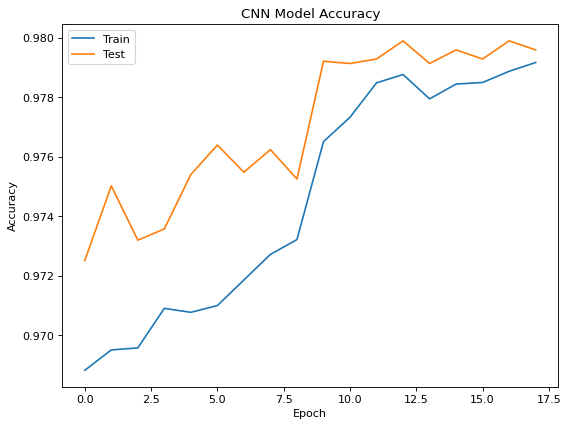

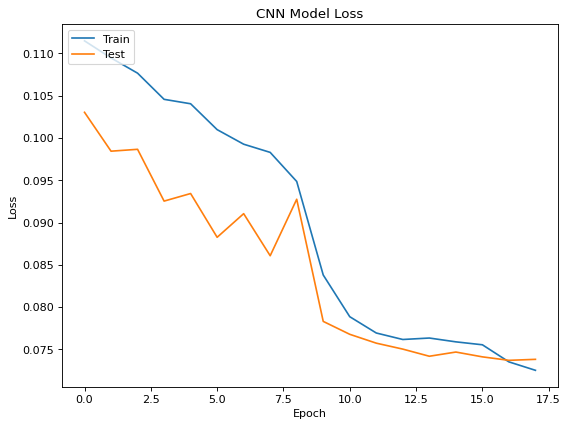

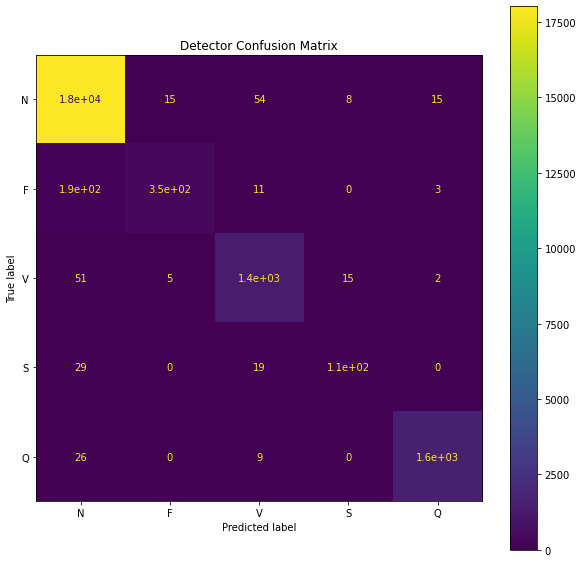

In [13]:

model.evaluate(X_test, Y_test)

plt.figure(figsize=(8, 6), dpi=80)

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.figure(figsize=(8, 6), dpi=80)

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

conf = ConfusionMatrixDisplay(confusion_matrix(Y_test, pred_test),['N','F','V','S','Q'])
#plot_confusion_matrix(confusion_matrix(Y_test, pred_test), ['N','F','V','S','Q'],normalize= True)
fig, ax = plt.subplots(figsize=(10,10))
plt.title("Detector Confusion Matrix")
conf.plot(ax=ax)
plt.savefig('/content/drive/Shareddrives/ECG/confdet.png')